## Data Visualization Notebook

To minimize notebook runtimes, vizualizations from the Tropical Storm Classification Project are being run separately here. 

### Recreating Dataframes

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/ibtracs.since1980.list.v04r00.csv', dtype='object', parse_dates=True, skiprows=[1], na_values=' ')
#drop first row as it's a multi index

pd.set_option('display.max_columns', None)
df.head(3)

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES,WMO_AGENCY,TRACK_TYPE,DIST2LAND,LANDFALL,IFLAG,USA_AGENCY,USA_ATCF_ID,USA_LAT,USA_LON,USA_RECORD,USA_STATUS,USA_WIND,USA_PRES,USA_SSHS,USA_R34_NE,USA_R34_SE,USA_R34_SW,USA_R34_NW,USA_R50_NE,USA_R50_SE,USA_R50_SW,USA_R50_NW,USA_R64_NE,USA_R64_SE,USA_R64_SW,USA_R64_NW,USA_POCI,USA_ROCI,USA_RMW,USA_EYE,TOKYO_LAT,TOKYO_LON,TOKYO_GRADE,TOKYO_WIND,TOKYO_PRES,TOKYO_R50_DIR,TOKYO_R50_LONG,TOKYO_R50_SHORT,TOKYO_R30_DIR,TOKYO_R30_LONG,TOKYO_R30_SHORT,TOKYO_LAND,CMA_LAT,CMA_LON,CMA_CAT,CMA_WIND,CMA_PRES,HKO_LAT,HKO_LON,HKO_CAT,HKO_WIND,HKO_PRES,NEWDELHI_LAT,NEWDELHI_LON,NEWDELHI_GRADE,NEWDELHI_WIND,NEWDELHI_PRES,NEWDELHI_CI,NEWDELHI_DP,NEWDELHI_POCI,REUNION_LAT,REUNION_LON,REUNION_TYPE,REUNION_WIND,REUNION_PRES,REUNION_TNUM,REUNION_CI,REUNION_RMW,REUNION_R34_NE,REUNION_R34_SE,REUNION_R34_SW,REUNION_R34_NW,REUNION_R50_NE,REUNION_R50_SE,REUNION_R50_SW,REUNION_R50_NW,REUNION_R64_NE,REUNION_R64_SE,REUNION_R64_SW,REUNION_R64_NW,BOM_LAT,BOM_LON,BOM_TYPE,BOM_WIND,BOM_PRES,BOM_TNUM,BOM_CI,BOM_RMW,BOM_R34_NE,BOM_R34_SE,BOM_R34_SW,BOM_R34_NW,BOM_R50_NE,BOM_R50_SE,BOM_R50_SW,BOM_R50_NW,BOM_R64_NE,BOM_R64_SE,BOM_R64_SW,BOM_R64_NW,BOM_ROCI,BOM_POCI,BOM_EYE,BOM_POS_METHOD,BOM_PRES_METHOD,NADI_LAT,NADI_LON,NADI_CAT,NADI_WIND,NADI_PRES,WELLINGTON_LAT,WELLINGTON_LON,WELLINGTON_WIND,WELLINGTON_PRES,DS824_LAT,DS824_LON,DS824_STAGE,DS824_WIND,DS824_PRES,TD9636_LAT,TD9636_LON,TD9636_STAGE,TD9636_WIND,TD9636_PRES,TD9635_LAT,TD9635_LON,TD9635_WIND,TD9635_PRES,TD9635_ROCI,NEUMANN_LAT,NEUMANN_LON,NEUMANN_CLASS,NEUMANN_WIND,NEUMANN_PRES,MLC_LAT,MLC_LON,MLC_CLASS,MLC_WIND,MLC_PRES,USA_GUST,BOM_GUST,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 00:00:00,TS,-12.5000,172.500,NaN,NaN,NaN,main,647,647,O________OO_O_,jtwc_sh,SH051980,-12.5000,172.500,NaN,NaN,25,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-12.5000,172.500,TC,25,NaN,-12.5000,172.500,1,25,NaN,NaN,NaN,NaN,NaN,NaN,-12.5000,172.500,TC,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,351
1,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 03:00:00,TS,-12.1927,172.441,NaN,NaN,NaN,main,653,653,P________PP_P_,NaN,SH051980,-12.1825,172.432,NaN,NaN,25,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-12.1825,172.432,TC,25,NaN,-12.2234,172.469,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-12.1825,172.432,TC,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,351
2,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 06:00:00,TS,-11.9144,172.412,NaN,NaN,NaN,main,670,670,O________OP_O_,jtwc_sh,SH051980,-11.9000,172.400,NaN,NaN,25,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11.9000,172.400,TC,25,NaN,-11.9575,172.450,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11.9000,172.400,TC,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,358


In [3]:
df.columns = [x.lower() for x in df.columns]

In [4]:
#removing unclassified rows
df.drop(df.loc[df['nature'] == 'NR'].index, inplace=True)
df.drop(df.loc[df['nature'] == 'MX'].index, inplace=True)

#new column  
df['target'] = 0

# loop through the data and input a 1 where the storm is a Tropical storm
for row in df.index:
    if df['nature'][row] == 'TS':
        df['target'][row] = 1

In [6]:
initial_feats = ['sid', 'season', 'basin', 'subbasin', 'lat', 'lon', 
                 'wmo_wind', 'dist2land', 'storm_speed', 'storm_dir']
xs_df = df[initial_feats]

xs_df[['lat', 'lon', 'dist2land', 'season', 'wmo_wind', 'storm_speed', 'storm_dir']] = xs_df[['lat', 'lon', 'dist2land', 'season', 'wmo_wind', 'storm_speed', 'storm_dir']].apply(pd.to_numeric)

#taking my datetime object and pulling out the week as a feature
df['iso_time'] = pd.to_datetime(df['iso_time'])
xs_df['week_of_year'] = df['iso_time'].dt.week

In [8]:
y_df = df['target'].to_frame()
clean_df = pd.concat([xs_df, y_df], axis=1)
clean_df.head()

,sid,season,basin,subbasin,lat,lon,wmo_wind,dist2land,storm_speed,storm_dir,week_of_year,target
0,1980001S13173,1980,SP,MM,-12.5000,172.500,NaN,647,6.0,351.0,1,1
1,1980001S13173,1980,SP,MM,-12.1927,172.441,NaN,653,6.0,351.0,1,1
2,1980001S13173,1980,SP,MM,-11.9144,172.412,NaN,670,5.0,358.0,1,1
3,1980001S13173,1980,SP,MM,-11.6863,172.435,NaN,682,4.0,12.0,1,1
4,1980001S13173,1980,SP,MM,-11.5000,172.500,NaN,703,4.0,22.0,1,1


In [9]:
grouped_df = clean_df.groupby(['sid']).max()
grouped_df.head()

,season,lat,lon,wmo_wind,dist2land,storm_speed,storm_dir,week_of_year,target
sid,,,,,,,,,
1980001S13173,1980,-11.1525,189.5,65.0,934,22.0,358.0,1,1
1980002S15081,1980,-13.8825,80.0,29.0,2230,7.0,320.0,1,1
1980003S15137,1980,-14.6600,161.0,50.0,818,26.0,237.0,2,1
1980005S11059,1980,-11.0000,59.0,25.0,1014,35.0,308.0,1,1
1980005S14120,1980,-13.6333,120.7,115.0,490,20.0,339.0,2,1


### Feature Exploration Visualizations

(11, 0)

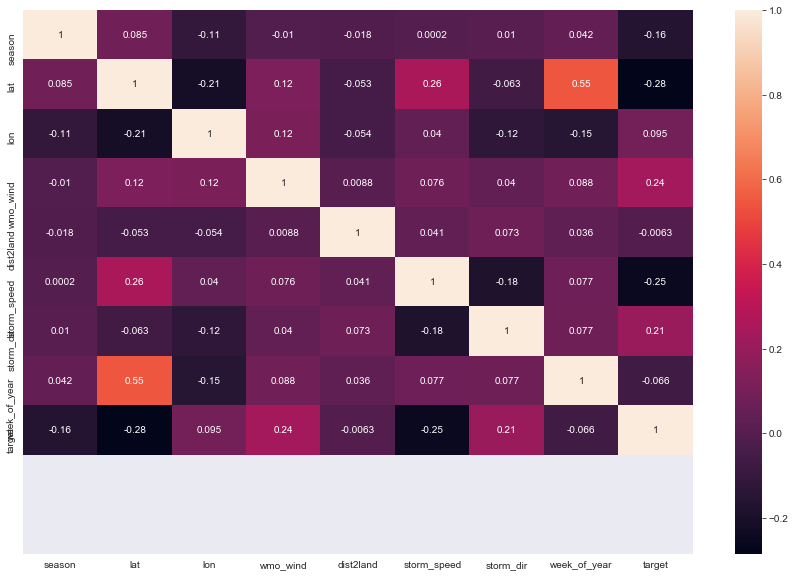

In [10]:
#removing non-numericals
plot_df = clean_df.drop(['subbasin', 'basin'], axis=1)

plt.figure(figsize = (15,10))
ax = sns.heatmap(plot_df.corr(), annot=True)
ax.set_ylim(11,0)

In [ ]:
plt.figure(figsize=(10,8))

sns.pairplot(plot_df, hue='target', y_vars='target')